<a href="https://colab.research.google.com/github/AllanKamimura/AI/blob/master/Satelite_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic detection in satellite images with Convolutional Neural Network and TensorFlow 2.x

3 datasets with different detection goals:
1.   Satellite images with High Latitude Dust (87 images) \
\> https://github.com/nasa/spaceapps-phenomena_detection/tree/dev/data/labeled
2.   Satellite images with Water Bodies (2841 images) \
\> https://www.kaggle.com/franciscoescobar/satellite-images-of-water-bodies

two models:

1.   *NN version 1:* 10 convolutional layers in Sequential 
2.   *NN version 2:* U-net architeture with 3 MaxPooling layers








# Init
Import python libraries and define variables

In [1]:
#prepare data
import os
import random
import zipfile
from google_drive_downloader import GoogleDriveDownloader

#important libraries
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#upload test images
from google.colab import files

#create saves/loads
import datetime
import ipywidgets 
from keras.utils.vis_utils import plot_model


**Create folder tree:**
```
── train
    ├── image
    │   └──  img
    │        ├── Satelite_image1.tiff
    │        ├── Satelite_image2.tiff
    │        └──  ...
    └── mask
        └──  img
             ├── Mask1_bitmap.png
             ├── Mask2_bitmap.png
             └──  ...
```

In [2]:
def create_folders(): 
    try: #if directory doesn't exists, make directory 
        os.mkdir(main_path)
    except Exception as e:
        print(e)

    try: #if directory doesn't exists, make directory 
        os.mkdir(train_path)
        os.mkdir(val_path)
    except Exception as e:
        print(e)

    try: #if directory doesn't exists, make directory 
        os.mkdir(save_path)
    except Exception as e:
        print(e)

    try: #if directory doesn't exists, make directory
        os.mkdir(train_path + "/image")
        os.mkdir(train_path + "/image/img")

        os.mkdir(train_path + "/mask")
        os.mkdir(train_path + "/mask/img")

        os.mkdir(val_path + "/image")
        os.mkdir(val_path + "/image/img")

        os.mkdir(val_path + "/mask")
        os.mkdir(val_path + "/mask/img")
    except Exception as e:
        print(e)
    return "folders ok"            

In [3]:
def split_data_dust(val_split):
    global val_images #global variable, I'm going to use this to show the images later
    dust_path = download_path + "/dust"
    images = [arquivo for arquivo in os.listdir(dust_path) if ".tiff" in arquivo] #image format .tiff, mask format .bitmap
    k = int(len(images)*(val_split/100)) #sample length
    val_images = random.sample(images, k = k) #list with val_images file names

    for image in images:
        if image in val_images: #separate val images
            os.rename(os.path.join(dust_path, image), val_path + "/image/img/" + image) #change the absolute path of the image
            name, _ = image.split(".") #get filename without extension
            image = name + "_bitmap.png" #mask, same filename but with .bitmap extension
            os.rename(os.path.join(dust_path, image), val_path + "/mask/img/" + image)
        else: #separate train images
            os.rename(os.path.join(dust_path, image), train_path + "/image/img/" + image) #change the absolute path of the image
            name, _ = image.split(".") #get filename without extension
            image = name + "_bitmap.png" #mask, same filename but with _bitmap.png extension
            os.rename(os.path.join(dust_path, image), train_path + "/mask/img/" + image)
    try:
        saves = [save for save in os.listdir(download_path + "/save")]
        for save in saves:
            os.rename(download_path + "/save/" + save, save_path + "/" + save)
    except Exception as e:
        print(e)

    print("copied {} training images and {} validation images".format(len(images) - len(val_images),len(val_images)))

In [4]:
def split_data_water(val_split):
    global val_images #global variable, I'm going to use this to show the images later
    water_path = download_path + "/Water Bodies Dataset"
    images = [arquivo for arquivo in os.listdir(water_path + "/Images")] #image format .tiff, mask format .bitmap
    k = int(len(images)*(val_split/100)) #sample length
    val_images = random.sample(images, k = k) #list with val_images file names

    for image in images:
        if image in val_images: #separate val images
            os.rename(water_path + "/Images/" + image, val_path + "/image/img/" + image) #change the absolute path of the image
            os.rename(water_path + "/Masks/" + image, val_path + "/mask/img/" + image)
        else: #separate train images
            os.rename(water_path + "/Images/" + image, train_path + "/image/img/" + image) #change the absolute path of the image
            os.rename(water_path + "/Masks/" + image, train_path + "/mask/img/" + image)

    try:
        saves = [save for save in os.listdir(download_path + "/save")]
        for save in saves:
            os.rename(download_path + "/save/" + save, save_path + "/" + save)
    except Exception as e:
        print(e)

    print("copied {} training images and {} validation images".format(len(images) - len(val_images),len(val_images)))

In [5]:
def split_data_custom(val_split):
    global val_images #global variable, I'm going to use this to show the images later
    custom_path = os.path.join(download_path,folder)
    images = [arquivo for arquivo in os.listdir(custom_path + "/image")] #image format .tiff, mask format .bitmap
    k = int(len(images)*(val_split/100)) #sample length
    val_images = random.sample(images, k = k) #list with val_images file names

    for image in images:
        if image in val_images: #separate val images
            os.rename(custom_path + "/image/" + image, val_path + "/image/img/" + image) #change the absolute path of the image
            os.rename(custom_path + "/mask/" + image, val_path + "/mask/img/" + image)
        else: #separate train images
            os.rename(custom_path + "/image/" + image, train_path + "/image/img/" + image) #change the absolute path of the image
            os.rename(custom_path + "/mask/" + image, train_path + "/mask/img/" + image)

    try:
        saves = [save for save in os.listdir(download_path + "/save")]
        for save in saves:
            os.rename(download_path + "/save/" + save, save_path + "/" + save)
    except Exception as e:
        print(e)

    print("copied {} training images and {} validation images".format(len(images) - len(val_images),len(val_images)))

# Getting things ready

In [6]:
#@title ## Set the main path { run: "auto", display-mode: "form" }
#@markdown Train and Val folders follows the main path

#@markdown ---
#@markdown ### Enter the main path:
main_path = "/home/dust" #@param {type:"string"}
download_path = "/tmp" #@param {type:"string"}
#@markdown ---

#folder paths
train_path = main_path + "/train"
val_path = main_path + "/val"
save_path = main_path + "/save"

In [7]:
#@title Split data into train and val { run: "auto", display-mode: "form" }
#@markdown Set percent of the dataset to be used to validate the model
val_split = 20 #@param {type:"slider", min:0, max:100, step:1}


## High Latitude Dust (HDL)
original dataset from [https://github.com/nasa/spaceapps-phenomena_detection/tree/dev/data/labeled](https://github.com/nasa/spaceapps-phenomena_detection/tree/dev/data/labeled)

 `aws s3://impact-datashare/hld-labeled`


In [8]:
#Download dataset files (High Latitude Dust)
#original data from https://github.com/nasa/spaceapps-phenomena_detection/tree/dev/data/labeled
#s3://impact-datashare/hld-labeled

GoogleDriveDownloader.download_file_from_google_drive(file_id = "12eTl6ViqwpBb4uLBtPo5QK1MZcUHuezR",
                                                      dest_path = "/tmp/dust.zip",
                                                      unzip = True)
create_folders()
split_data_dust(val_split = val_split)

Unzipping...Done.
copied 70 training images and 17 validation images


## Water bodies Dataset
original dataset from [https://www.kaggle.com/franciscoescobar/satellite-images-of-water-bodies](https://www.kaggle.com/franciscoescobar/satellite-images-of-water-bodies)

OBS:
- this dataset is a lot bigger than the dust one, so expect thing to go slower
- some images are pretty bad cropped / low resolution
- also, if you are going to try your own images, note that there's no clouds in the images from the dataset

In [ ]:
# #to use this dataset, un-comment this cell with "Ctrl + A", "Crtl + /"
# #please, also change the main_path to /home/water

# GoogleDriveDownloader.download_file_from_google_drive(file_id = "12v-8JgUDp7DOXKCiME_bXah8ywK0dRpC",
#                                                       dest_path = "/tmp/water.zip",
#                                                       unzip = True)

# create_folders()
# split_data_water(val_split = val_split)


Unzipping...Done.
copied 2273 training images and 568 validation images


## Use your own Dataset
1.   format your dataset folder like this:
```
── [yourdataset]
        ├── image
        │     ├── image1.png
        │     ├── image2.png
        │     └──  ...
        └── mask
             ├── Mask1.png
             ├── Mask2.png
             └──  ...
```
2.   zip the folder into a zip file



3.   either upload it to `download_path` or pass a google drive id 

you can change `download_path` to "/content", if it helps

*upload is really slow, so I recommend the google drive ID approach, make sure that the link is set to public*


In [ ]:
# # #to use this dataset, un-comment this cell with "Ctrl + A", "Crtl + /"
# # #please, also change the main_path to /home/yourpath

# #[yourdataset] folder name:
# folder = "[yourdataset]" # un-commnent and type folder name remove brackets

# #id = "" # un-commnent and type the id, you still need to type the folder name above
# #GoogleDriveDownloader.download_file_from_google_drive(file_id = id,
# #                                                       dest_path = "/tmp/" + folder + ".zip",
# #                                                       unzip = True)


# with zipfile.ZipFile(os.path.join(download_path,folder + ".zip"), 'r') as zip_ref:
#     zip_ref.extractall(download_path)

# create_folders()
# split_data_custom(val_split = val_split)


# Take a look at some examples from images the train dataset 

In [19]:
def look_dataset(image, look_path):

    x_path = look_path + "/image/img"
    input = tf.keras.preprocessing.image.load_img(os.path.join(x_path,image), target_size = (256,256))
    
    image, _ = image.split(".")

    y_path = look_path + "/mask/img"
    for mask in os.listdir(y_path):
        if image in mask:
            image = mask
            break
    groundtruth  = tf.keras.preprocessing.image.load_img(os.path.join(y_path,image), target_size = (256,256))

    fig = plt.figure(figsize = (10, 10))
    fig.add_subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(input)

    fig.add_subplot(1, 2, 2)
    plt.title("mask")
    plt.imshow(groundtruth)



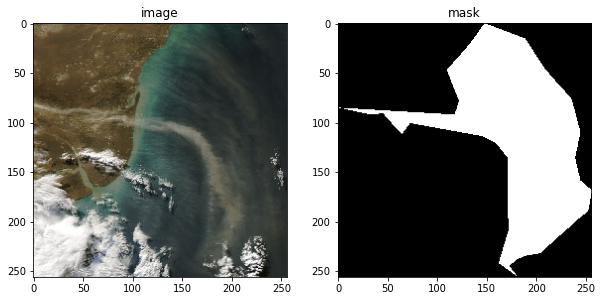

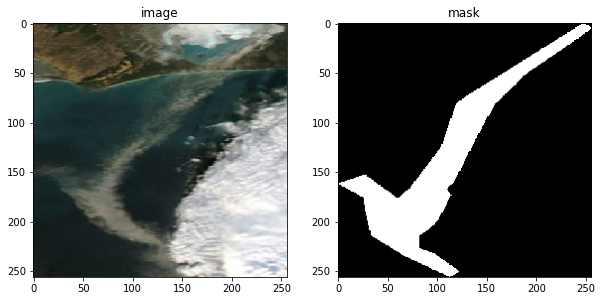

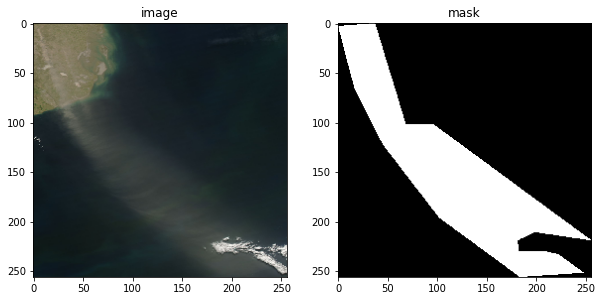

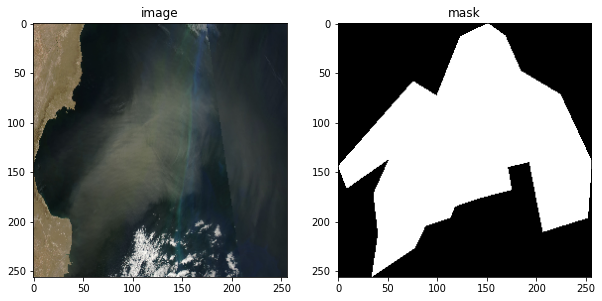

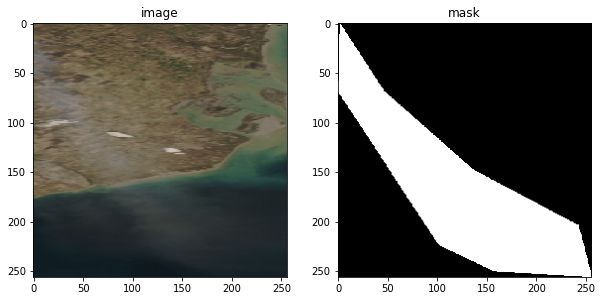

In [20]:
look_path = train_path #either train_path or val_path
sample_image = random.sample(os.listdir(look_path + "/image/img"),
                             5) #number of samples
for i in sample_image:
    look_dataset(i,look_path = look_path)


# Load model (can be skipped)
here, there's some pre-trained weighs, you can either use those loads as-is or use it as starting point to get faster and better results

nevertheless, you can also ignore this section for now and retrain the weights from the start

---
how to load the weights:


1.   run the select the save cell and select the save data to load
2.   run this one cell
3.   don't run `model.fit`, unless you want to overwrite the loaded weights



In [ ]:
# select save data
saves = os.listdir(save_path)
save = ipywidgets.Dropdown(options = saves)
save

Dropdown(options=('dust_NN1.h5', 'dust_NN2.h5'), value='dust_NN1.h5')

In [ ]:
# load model
model = tf.keras.models.load_model(os.path.join(save_path, save.value))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 256, 256, 64) 1792        input_layer[0][0]                
__________________________________________________________________________________________________
activation_34 (Activation)      (None, 256, 256, 64) 0           conv2d_64[0][0]                  
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 256, 256, 64) 256         activation_34[0][0]              
____________________________________________________________________________________________

In [ ]:
# model visualization, datatime from the last saved model
plot_model(model, to_file = save_path + "/model_" + now + ".png", show_shapes = True)

# NN

## NN version 1

In [21]:
# preprocess the images and mask; and feed to data generator 
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# details on https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
seed = 2
train_image_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest') 

train_mask_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest')  

train_image_generator = train_image_datagen.flow_from_directory(
    train_path + "/image",
    class_mode = None, 
    seed = seed,
    color_mode = "rgb",
    batch_size = 15,
    target_size = (256,256))

train_mask_generator = train_mask_datagen.flow_from_directory(
    train_path + "/mask",
    class_mode = None, 
    seed = seed,
    color_mode = "grayscale",
    batch_size = 15,
    target_size = (256,256))

train_generator = zip(train_image_generator, train_mask_generator)

val_image_datagen = ImageDataGenerator(
    rescale = 1./255.)

val_mask_datagen = ImageDataGenerator(
    rescale = 1./255.) 

val_image_generator = val_image_datagen.flow_from_directory(
    val_path + "/image",
    class_mode = None, 
    seed = seed,
    color_mode = "rgb",
    batch_size = 15,
    target_size = (256,256))

val_mask_generator = val_mask_datagen.flow_from_directory(
    val_path + "/mask",
    class_mode = None, 
    seed = seed,
    color_mode = "grayscale",
    batch_size = 15,
    target_size = (256,256))

val_generator = zip(val_image_generator, val_mask_generator)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 70 images belonging to 1 classes.
Found 70 images belonging to 1 classes.
Found 17 images belonging to 1 classes.
Found 17 images belonging to 1 classes.


In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(96, (3,3), activation = 'relu', padding = "same", input_shape = (256, 256, 3)),
    tf.keras.layers.Conv2D(96, (3,3), activation = 'relu', padding = "same"),
    tf.keras.layers.Conv2D(96, (3,3), activation = 'relu', padding = "same"),
    tf.keras.layers.LayerNormalization(axis = [1,2]),

    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation = 'swish', padding = "same"),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'swish', padding = "same"),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'swish', padding = "same"),
    tf.keras.layers.LayerNormalization(axis = [1,2]),
    
    tf.keras.layers.UpSampling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation = 'swish', padding = "same"),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'swish', padding = "same"),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'swish', padding = "same"),
    tf.keras.layers.LayerNormalization(axis = [1,2]),
    
    tf.keras.layers.Conv2D(1, (3,3), activation = 'sigmoid', padding = "same")  
])

model.compile(
    optimizer = "Adam",
    loss = 'binary_crossentropy',
    metrics = ['MSE', "accuracy"])


In [25]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 20, restore_best_weights = True)
results = model.fit(
    train_generator,
    epochs = 50,
    steps_per_epoch = 20, 
    validation_data = val_generator,
    validation_steps = 20,
    callbacks = [callback]
)

Epoch 1/50
20/20 [==============================] - 22s 1s/step - loss: 0.9124 - MSE: 0.2930 - accuracy: 0.5505 - val_loss: 0.5381 - val_MSE: 0.1789 - val_accuracy: 0.7345
Epoch 2/50
20/20 [==============================] - 20s 1s/step - loss: 0.5769 - MSE: 0.1939 - accuracy: 0.6938 - val_loss: 0.4828 - val_MSE: 0.1566 - val_accuracy: 0.7772
Epoch 3/50
20/20 [==============================] - 20s 1s/step - loss: 0.5381 - MSE: 0.1773 - accuracy: 0.7257 - val_loss: 0.4666 - val_MSE: 0.1509 - val_accuracy: 0.7840
Epoch 4/50
20/20 [==============================] - 20s 1s/step - loss: 0.4960 - MSE: 0.1584 - accuracy: 0.7636 - val_loss: 0.4701 - val_MSE: 0.1526 - val_accuracy: 0.7803
Epoch 5/50
20/20 [==============================] - 20s 1s/step - loss: 0.4781 - MSE: 0.1525 - accuracy: 0.7704 - val_loss: 0.4512 - val_MSE: 0.1462 - val_accuracy: 0.7857
Epoch 6/50
20/20 [==============================] - 20s 1s/step - loss: 0.4631 - MSE: 0.1458 - accuracy: 0.7837 - val_loss: 0.4556 - val_MSE

## NN version2

In [32]:
# ImageDataGenerator with a preprocessing_function
def normalize_image(image):
    image = image / 255.0
    return image

def normalize_mask(image): # both fuctions are the same, but you could make some changes 
    image = image / 255.0
    return image

train_image_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
    preprocessing_function = normalize_image) 

train_mask_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
    preprocessing_function = normalize_mask)

val_image_datagen = ImageDataGenerator(
    preprocessing_function = normalize_image)

val_mask_datagen = ImageDataGenerator(
    preprocessing_function = normalize_mask)

def generator(generatorX, generatorY, X, Y):
    seed = 2 

    genX = generatorX.flow_from_directory(
        X,
        class_mode = None, 
        seed = seed,
        batch_size = 15,
        target_size = (256,256))
    
    genY = generatorY.flow_from_directory(
        Y,
        class_mode = None, 
        seed = seed,
        batch_size = 15,
        color_mode = "grayscale",
        target_size = (256,256))

    while True:
        Xi = genX.next()
        Yi = genY.next()
        yield Xi, Yi

In [33]:
# unet with 3 residual layers [x1,x2,x3]
# you could put the blocks inside a function to reuse code, but I choose a more straighfoward visualization
def unet_base(input_shape):
    base_unit = 32

    input = tf.keras.layers.Input(shape = input_shape, name = "input_layer")

    #conv block 1
    x = tf.keras.layers.Conv2D( base_unit , (3,3), activation = None, padding = "same", kernel_initializer = "he_normal")(input)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D( base_unit , (3,3), activation = None, padding = "same", kernel_initializer = "he_normal")(x)
    x = tf.keras.layers.BatchNormalization()(x) 
    x1 = tf.keras.layers.Activation("relu", name = "residual_1")(x) #Residual layer 1, shape = input_shape

    x = tf.keras.layers.Conv2D( base_unit , (3,3), activation = None, padding = "same", kernel_initializer = "he_normal")(x1)
    x = tf.keras.layers.BatchNormalization()(x) 
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.MaxPool2D((2,2))(x) #shape = input_shape / 2
    x = tf.keras.layers.Dropout(0.3)(x)

    #conv block 2
    x = tf.keras.layers.Conv2D( 2 * base_unit , (3,3), activation = None, padding = "same", kernel_initializer = "he_normal")(x)
    x = tf.keras.layers.BatchNormalization()(x) 
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D( 2 * base_unit , (3,3), activation = None, padding = "same", kernel_initializer = "he_normal")(x)
    x = tf.keras.layers.BatchNormalization()(x) 
    x2 = tf.keras.layers.Activation("relu", name = "residual_2")(x) #Residual layer 2, shape = input_shape / 2

    x = tf.keras.layers.Conv2D( 2 * base_unit , (3,3), activation = None, padding = "same", kernel_initializer = "he_normal")(x2)
    x = tf.keras.layers.BatchNormalization()(x) 
    x = tf.keras.layers.Activation("relu")(x)
    
    x = tf.keras.layers.MaxPool2D((2,2))(x) #shape = input_shape / 4
    x = tf.keras.layers.Dropout(0.3)(x)
    
    #conv block 3
    x = tf.keras.layers.Conv2D( 4 * base_unit , (3,3), activation = None, padding = "same", kernel_initializer = "he_normal")(x)
    x = tf.keras.layers.BatchNormalization()(x) 
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D( 4 * base_unit , (3,3), activation = None, padding = "same", kernel_initializer = "he_normal")(x)
    x = tf.keras.layers.BatchNormalization()(x) 
    x3 = tf.keras.layers.Activation("relu", name = "residual_3")(x) #Residual layer 3, shape = input_shape / 4

    x = tf.keras.layers.Conv2D( 4 * base_unit , (3,3), activation = None, padding = "same", kernel_initializer = "he_normal")(x3)
    x = tf.keras.layers.BatchNormalization()(x) 
    x = tf.keras.layers.Activation("relu")(x)
    
    x = tf.keras.layers.MaxPool2D((2,2))(x) #shape = input_shape / 8
    x = tf.keras.layers.Dropout(0.3)(x)
    
    #conv block 4 (bottom)
    x = tf.keras.layers.Conv2D( 8 * base_unit, (3,3), activation = None, padding = "same", kernel_initializer = "he_normal")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D( 8 * base_unit, (3,3), activation = None, padding = "same", kernel_initializer = "he_normal")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    #conv up 1
    x = tf.keras.layers.Conv2DTranspose( 4 * base_unit, (3,3), activation = None, 
                                        padding = "same", strides = (2, 2))(x) #Deconvolution shape = input_shape / 4
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Concatenate()([x,x3]) #concatenate residual layer 3
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Conv2D( 4 * base_unit , (3,3), activation = None, padding = "same", kernel_initializer = "he_normal")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x) 

    x = tf.keras.layers.Conv2D( 4 * base_unit , (3,3), activation = None, padding = "same", kernel_initializer = "he_normal")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x) 
    
    #conv up 2
    x = tf.keras.layers.Conv2DTranspose( 2 * base_unit, (3,3), activation = None, 
                                        padding = "same", strides = (2, 2))(x) #Deconvolution shape = input_shape / 2
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Concatenate()([x,x2]) #concatenate residual layer 2
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Conv2D( 2 * base_unit , (3,3), activation = None, padding = "same", kernel_initializer = "he_normal")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x) 

    x = tf.keras.layers.Conv2D( 2 * base_unit , (3,3), activation = None, padding = "same", kernel_initializer = "he_normal")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x) 

    #conv up 3
    x = tf.keras.layers.Conv2DTranspose( 1 * base_unit, (3,3), activation = None, 
                                        padding = "same", strides=(2, 2))(x) #Deconvolution shape = input_shape
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Concatenate()([x,x1]) #concatenate residual layer 1
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Conv2D( 1 * base_unit , (3,3), activation = None, padding = "same", kernel_initializer = "he_normal")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x) 

    x = tf.keras.layers.Conv2D( 1 * base_unit , (3,3), activation = None, padding = "same", kernel_initializer = "he_normal")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x) 

    #output
    y = tf.keras.layers.Conv2D(1, (1,1),activation = "sigmoid", name = "output_layer")(x)

    model = tf.keras.models.Model(
        inputs = input,
        outputs = y)
    
    return model

model = unet_base(input_shape = (256, 256, 3))

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005), 
              loss = {"output_layer" : "binary_crossentropy"},
              metrics = {"output_layer" : ["accuracy"]}
              )
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 32) 9248        activation[0][0]                 
______________________________________________________________________________________________

In [34]:
# if you are not too patient, you can lower the "patience"               ↓ HERE  ↓
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 20, restore_best_weights = True)
history = model.fit(
    generator(train_image_datagen, train_mask_datagen, train_path + "/image", train_path + "/mask"),
    epochs = 200,
    batch_size = 10,
    steps_per_epoch = 20,
    verbose = 1,
    validation_data = generator(val_image_datagen, val_mask_datagen, val_path + "/image", val_path + "/mask"),
    validation_steps = 20,
    callbacks = [callback]
    )


Found 70 images belonging to 1 classes.
Found 70 images belonging to 1 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Epoch 1/200
20/20 [==============================] - ETA: 0s - loss: 0.7528 - accuracy: 0.5506Found 17 images belonging to 1 classes.
Found 17 images belonging to 1 classes.
20/20 [==============================] - 19s 774ms/step - loss: 0.7477 - accuracy: 0.5549 - val_loss: 6.4730 - val_accuracy: 0.4819
Epoch 2/200
20/20 [==============================] - 13s 681ms/step - loss: 0.5303 - accuracy: 0.7560 - val_loss: 15.1350 - val_accuracy: 0.4625
Epoch 3/200
20/20 [==============================] - 13s 678ms/step - loss: 0.5067 - accuracy: 0.7626 - val_loss: 16.1131 - val_accuracy: 0.4586
Epoch 4/200
20/20 [==============================] - 13s 671ms/step - loss: 0.5061 - accuracy: 0.7589 - val_loss: 26.6146 - val_accuracy: 0.4584
Epoch 5/200
20/20 [==============================] - 13s 679ms/step - loss: 0.5071 - accuracy: 0.7643 - val_loss: 11.9684 - val_accuracy: 0.4586
Epoch 6/200
20/20 [==============================] - 13s 682ms/step - loss: 0.4653 - accuracy: 0.7745 - val_loss: 

# predict results

In [26]:
def predict(path, threshold):
    input = tf.keras.preprocessing.image.load_img(path, target_size = (256,256))
    fig = plt.figure(figsize = (20, 20))
    input_arr = tf.keras.preprocessing.image.img_to_array(input)
    input_arr = np.array(input_arr) 
    input_arr = input_arr/255.0

    fig.add_subplot(1, 4, 1)
    plt.title("input")
    plt.imshow(input_arr)

    fig.add_subplot(1, 4, 2)
    input_predict = np.reshape(input_arr,(1,256,256,3))
    imagem = model.predict(input_predict)
    imagem = imagem * 255.0
    imagem = imagem.astype(int)
    imagem = np.reshape(imagem,(256,256))
    plt.title("output")
    plt.imshow(imagem)

    fig.add_subplot(1, 4, 3)
    mask = imagem < threshold
    plt.title("mask overlay")
    plt.imshow(input_arr)
    plt.imshow(np.ma.masked_where(mask,a = imagem),alpha=0.45,cmap='PuRd')

    fig.add_subplot(1, 4, 4)
    binary = np.where(mask < 0.5, 1, 0)
    binary = np.stack([binary,binary,binary],axis=2)

    result = input_arr * binary
    plt.title("binary mask")
    plt.imshow(result) 

    plt.show()

In [27]:
def upload(threshold):
    uploaded = files.upload()
    for image in uploaded.keys():
        path = '/content/' + image
        predict(path = path,
                threshold = threshold)

# See predicts

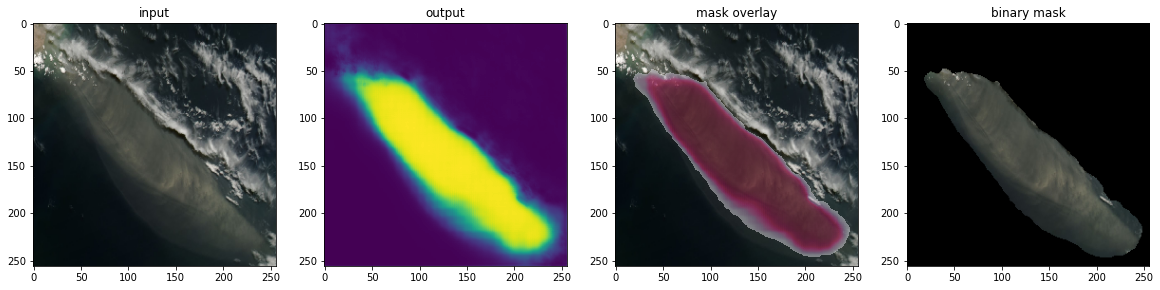

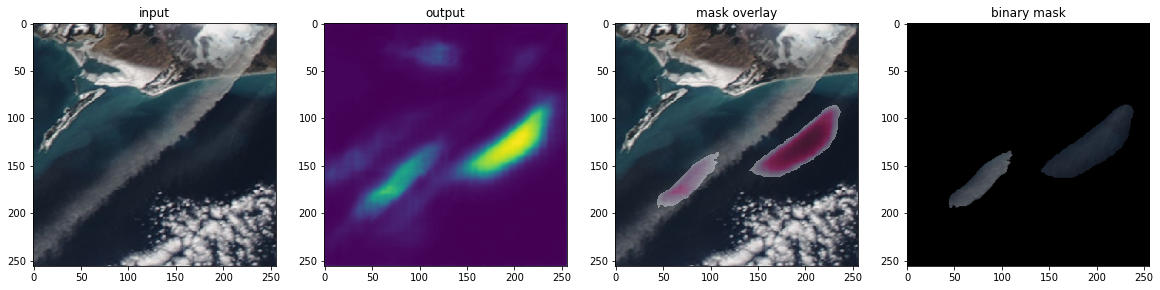

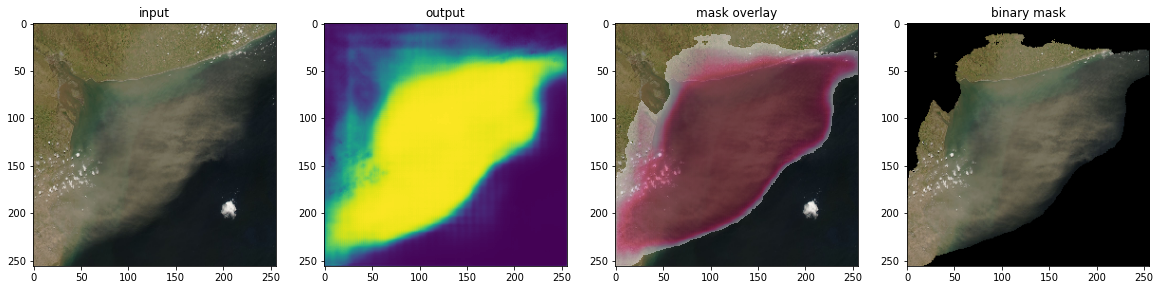

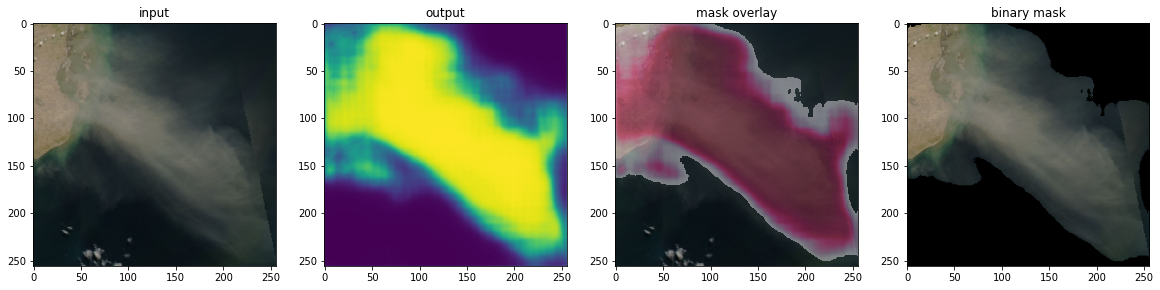

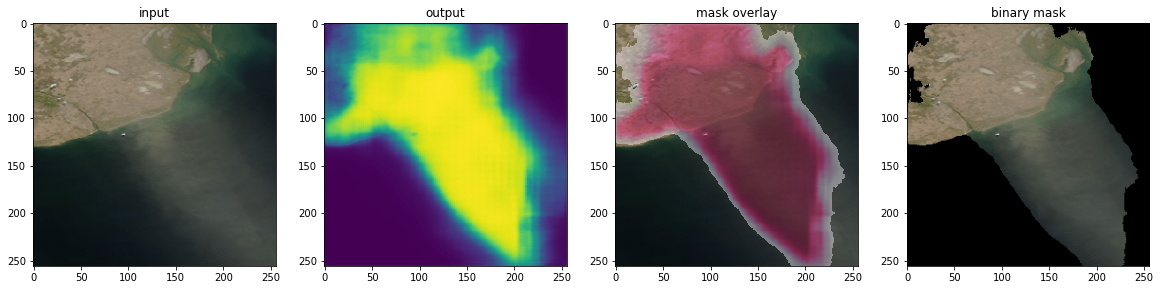

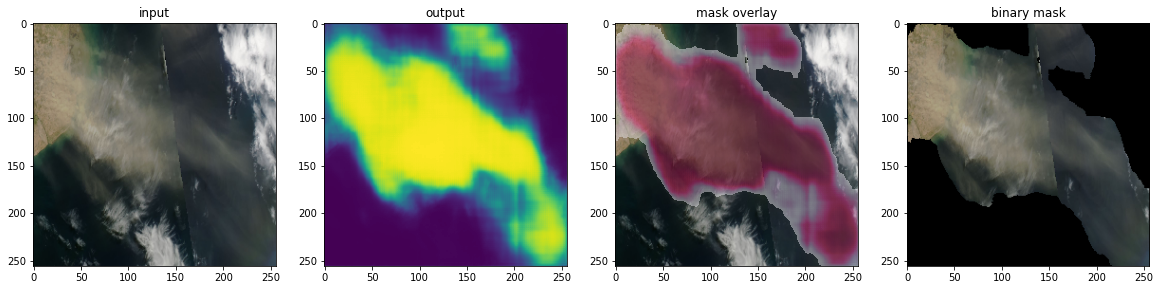

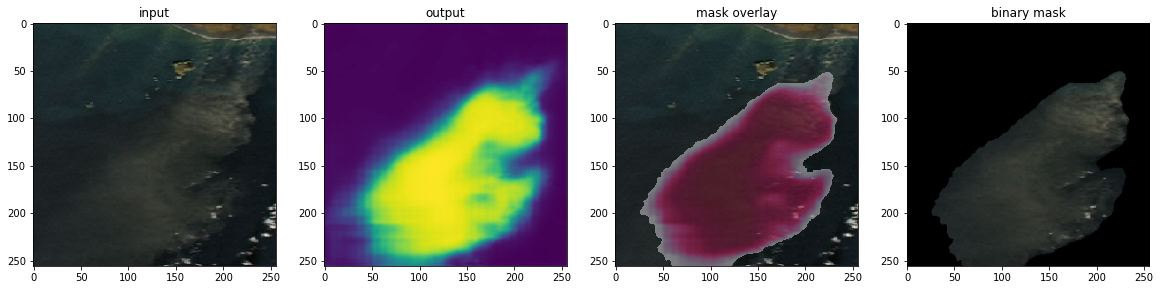

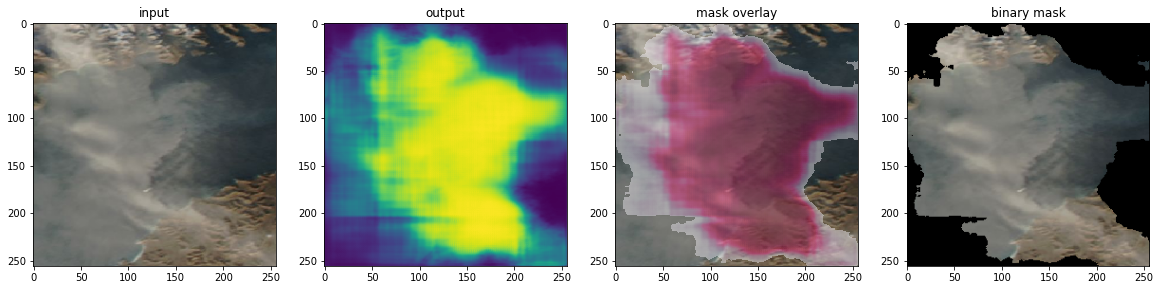

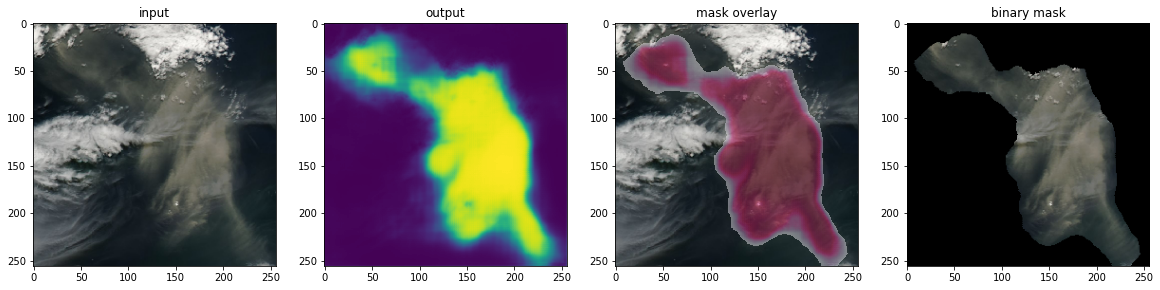

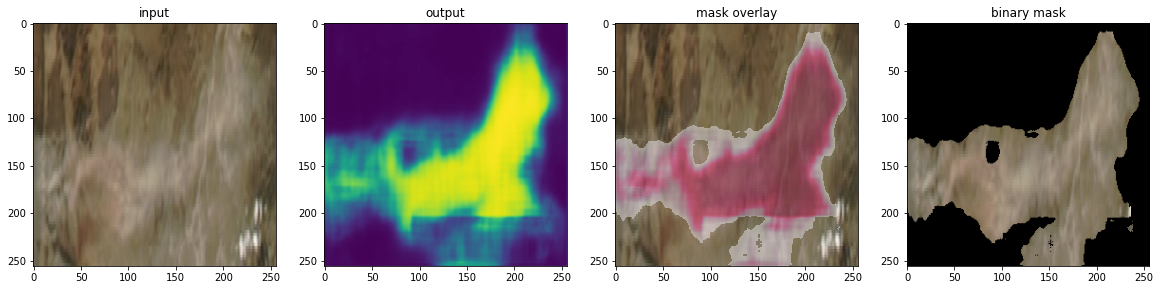

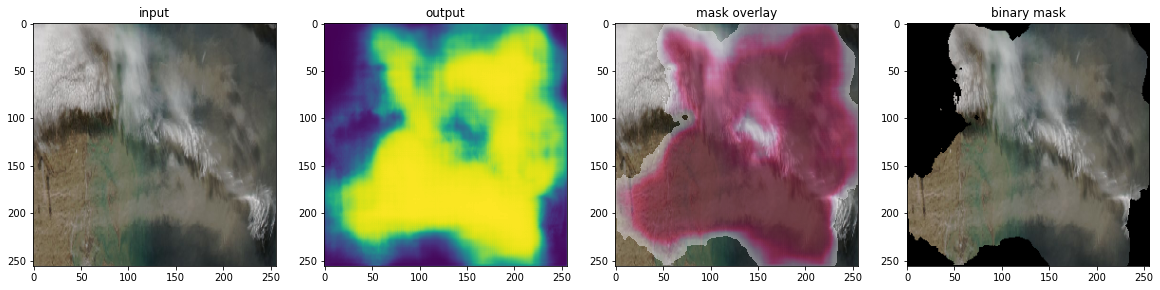

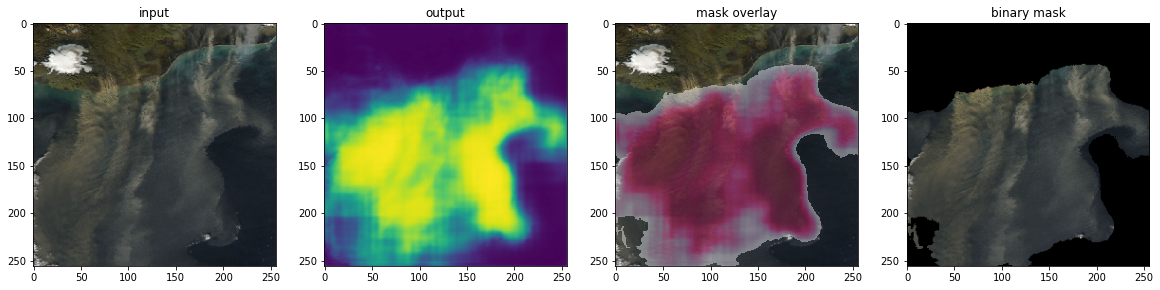

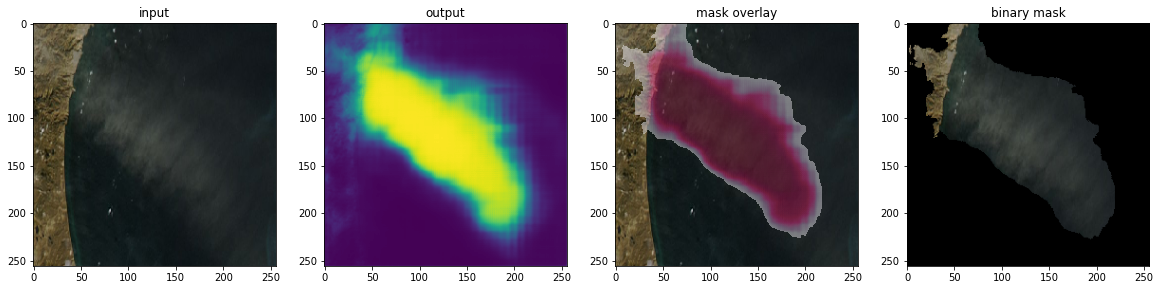

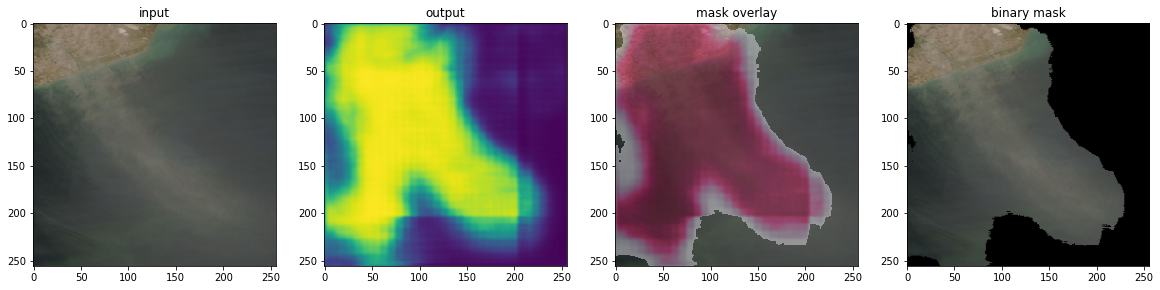

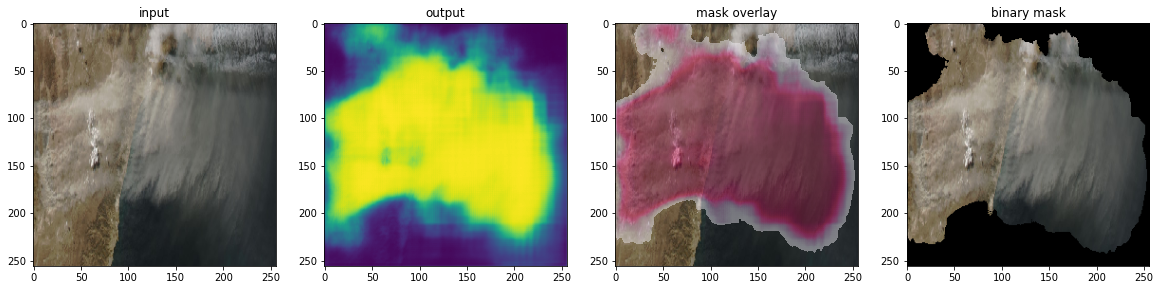

In [36]:
val_images_path = val_path + "/image/img"
imagems = random.sample(os.listdir(val_images_path),15)
for imagem in imagems:
    predict(os.path.join(val_images_path,imagem),
                         threshold = 70) #mask overlay threshold

Saving Screenshot_583.jpg to Screenshot_583.jpg


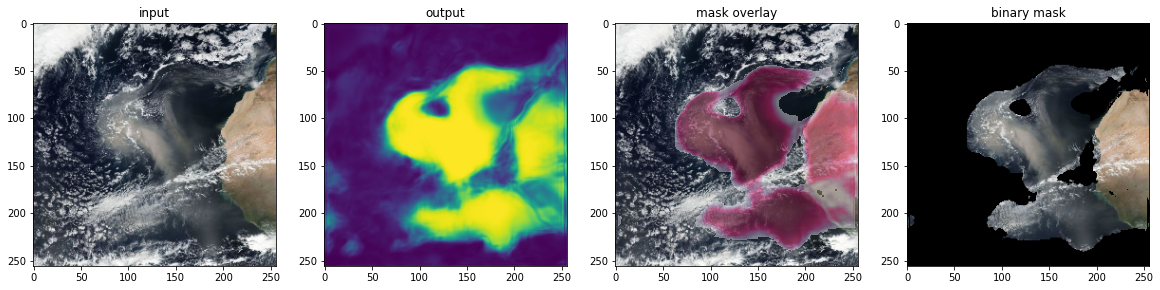

In [31]:
#run this cell to upload your own images
upload(threshold = 100)

# Save model
saves **are not preserved** *through sessions* 

if you want to keep it, either run the **download** cell or save it in **your drive**

In [ ]:
# save model
now = datetime.datetime.now()
now = "{}_{}_{}_{}_{}".format(now.year,now.month,now.day,now.hour,now.minute)
model.save(save_path + "/model_" + now + ".h5")

In [ ]:
# select save data
saves = os.listdir(save_path)
save = ipywidgets.Dropdown(options = saves)
save

Dropdown(options=('water_NN2.h5', 'model_2021_1_11_17_28.h5', 'water_NN1.h5'), value='water_NN2.h5')

In [ ]:
#download
files.download(os.path.join(save_path, save.value))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# model visualization, datatime from the last saved model
plot_model(model, to_file = save_path + "/model_" + now + ".png", show_shapes = True)